In [42]:
import pandas as pd, numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage import io

## gender_data파일을 불러온다.

---

64000여개의 사진에 대한 성별과 사진 url이 들어있다. (용량 문제)


메모리나 시간 관계상 2000개의 데이터만 사용할 것이나 많이 사용할 수록 성능은 향상될 것이다.

In [4]:
data = pd.read_csv('gender_data.csv')
data.head()

,_unit_id,sex,image_url
0,1023132475,male,https://d1qb2nb5cznatu.cloudfront.net/users/40...
1,1023132476,male,https://d1qb2nb5cznatu.cloudfront.net/users/42...
2,1023132477,male,https://d1qb2nb5cznatu.cloudfront.net/users/44...
3,1023132478,male,https://d1qb2nb5cznatu.cloudfront.net/users/47...
4,1023132479,male,https://d1qb2nb5cznatu.cloudfront.net/users/50...


## 데이터에는 남성/여성/불확실 3가지가 있으나 모델링에는 남,녀만 사용할 것이다.

In [5]:
data['sex'].value_counts()

male      47595
unsure     9122
female     7367
Name: sex, dtype: int64

## 남성, 여성 데이터를 각각 저장한다.

In [6]:
male_df = data[data['sex']=="male"].reset_index(drop='index')
female_df = data[data['sex']=="female"].reset_index(drop='index')

In [7]:
sex_data = pd.concat([male_df[:1000],female_df[:1000]],axis=0).reset_index(drop='index')
sex_data.shape

(2000, 3)

## 2000개의 사진의 url을 통해 실제 이미지를 가져와 저장한다.

---

이 때 300 * 300 pixel의 사진만 사용할 것이며 컬러사진만 모델에 훈련시킬 것이다.

In [8]:
features = []
targets = []
for i in range(sex_data.shape[0]):
    if(i%100==0):
        print(i)
    try:
        image = io.imread(sex_data.loc[i]['image_url']) #sklearn image의 io 패키지를 사용해 이미지를 url로부터 불러온다.
        if(image.shape==(300,300,3)): # 300*300은 이미지 사이즈를 3은 channel로 컬러이미지를 뜻한다.(1은 흑백)
            features.append(image)
            targets.append(sex_data.loc[i]['sex'])
    except :# 조건을 만족하지 않는 이미지는 사용하지 않는다.
        continue

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## 불러온 이미지를  imshow 함수를 이용해 간단하게 확인.

c:\users\anary\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


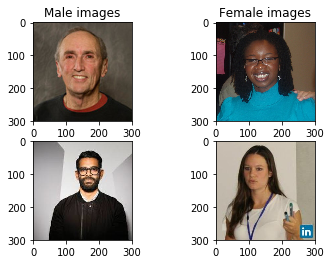

In [10]:
plt.subplot(221)
plt.imshow(features[0])
plt.title('Male images')
plt.grid('off')
plt.subplot(222)
plt.title('Female images')
plt.imshow(features[1000])
plt.grid('off')
plt.subplot(223)
plt.imshow(features[1])
plt.grid('off')
plt.subplot(224)
plt.imshow(features[1001])
plt.grid('off')
plt.show()

## 불러온 데이터들은 50 * 50 크기로 리사이즈할 것이며, 그레이 컬러로 변환해 학습시킨다.

In [27]:
import cv2

In [28]:
feature = []
target = []
for i in range(len(features)):
    img = cv2.cvtColor(features[i], cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img,(50,50))
    feature.append(img2)
    img_label = np.where(targets[i]=="male",1,0)
    target.append(img_label)

## Keras를 이용해 CNN 모델을 구현한다. 

In [30]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [31]:
feature = np.array(feature)

## 모델설명

---

모델은 4개의 Convolution layer, pooling layer를 가지며 뽑아낸 특징으로 단층 FNN(Feedfoward Neural Network, node num=100)에 넣어 최종 성별을 구분하는 모델이다. 활성화함수는 relu를 사용하였으며 마지막 output을 구하는 층은 sigmoid를 사용하였다. 

In [32]:
feature = feature.reshape(feature.shape[0],feature.shape[1],feature.shape[2],1)

In [33]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(50,50,1)))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv

## 손실함수는 crossentropy, optimizer는 adam, 결과는 정확도로 확인한다.

In [34]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## feature는 255까지의 수이므로 255를 나눠주고 feature와 target을 배열로 변환한다.

In [35]:
X = np.array(feature)/255
Y = np.array(target)

## 전처리가 완료된 데이터를 train,test , 9:1 비율로 임의로 나눈다.

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=11)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1577, 50, 50, 1) (176, 50, 50, 1) (1577,) (176,)


## 앞서 구현한 모델에 학습시킨다.

---
batch_size는 기본적으로 많이 사용하는 32개를 기준으로 잡았고 50회 반복시행했다. 

In [38]:
history = model.fit(X_train, y_train, batch_size=32,epochs=50,verbose=1,validation_data = (X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1577 samples, validate on 176 samples
Epoch 1/50
1577/1577 [==============================] - 4s 2ms/step - loss: 0.6942 - acc: 0.4997 - val_loss: 0.6936 - val_acc: 0.4830
Epoch 2/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.6917 - acc: 0.5168 - val_loss: 0.6777 - val_acc: 0.6420
Epoch 3/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.6638 - acc: 0.6132 - val_loss: 0.5936 - val_acc: 0.6591
Epoch 4/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.5808 - acc: 0.6817 - val_loss: 0.5616 - val_acc: 0.7102
Epoch 5/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.5154 - acc: 0.7457 - val_loss: 0.5460 - val_acc: 0.7045
Epoch 6/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.4446 - acc: 0.7964 - val_loss: 0.5417 - val_acc: 0.7330
Epoch 7/50
1577/1577 [==============================] - 3s 2ms/step - loss: 0.3868 - acc: 0.8148 - va

## 손실함수와 정확도를 저장해 결과를 시각화한다.

In [39]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

c:\users\anary\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


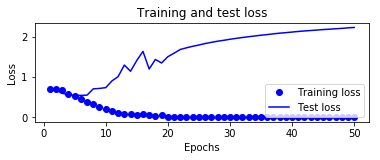

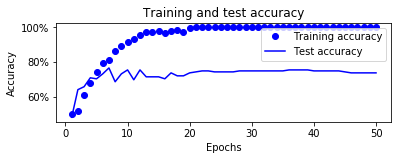

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()


In [46]:
print(acc_values)

[0.4996829423143959, 0.516804058395312, 0.6131896005828847, 0.6816740647931604, 0.745719721140405, 0.7964489537473713, 0.8148383006462964, 0.8623969562460367, 0.8922003805070416, 0.9188332277230242, 0.9340519975013346, 0.9594166138615121, 0.9727330374128091, 0.9733671528218135, 0.9816106531388713, 0.9676601141407736, 0.9790741915028536, 0.9873176918199112, 0.9765377298668357, 0.9961953075459734, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [47]:
print(loss_values)

[0.6942101329583946, 0.6917037565872952, 0.663809551191844, 0.5808293161395236, 0.5154372823336643, 0.44460680183157864, 0.38680702147411256, 0.3175692783459577, 0.24364681624126494, 0.20538828859770683, 0.16619444656916335, 0.10564564298850189, 0.06993200717117111, 0.07820471170427457, 0.05154489695118739, 0.07419961689367238, 0.06721557015594457, 0.04307265572776084, 0.06186795446575255, 0.013407887728824579, 0.0034392494325169946, 0.0012833824812419259, 0.0006917612021080275, 0.0004940007274900135, 0.0003898441039393263, 0.0003240199017298001, 0.00026376447442335243, 0.00021901755909596086, 0.00018586988034135113, 0.00016020238434310944, 0.00013821218001891945, 0.00012174960739986675, 0.00010656244835569246, 9.453937377498385e-05, 8.359450810682944e-05, 7.466847740494503e-05, 6.687262659741403e-05, 6.049046472006398e-05, 5.5212433918021366e-05, 4.944859151896809e-05, 4.5349318828219226e-05, 4.1588321151247105e-05, 3.7816561579905454e-05, 3.482206226773879e-05, 3.2057960421331495e-05

In [52]:
print(val_loss_values)

[0.6936069185083563, 0.6776712916114114, 0.5935958244583823, 0.5615741989829324, 0.5459641380743547, 0.5417487296191129, 0.5492382591420953, 0.7043091492219404, 0.7144981622695923, 0.7345509095625444, 0.899616848338734, 1.0067241516980259, 1.293237100947987, 1.1399236917495728, 1.4059850410981611, 1.6316760236566716, 1.1960476420142434, 1.431920745156028, 1.344280177896673, 1.5000253265554255, 1.5863485878164119, 1.6786297451366077, 1.720404570752924, 1.7575263868678699, 1.7893992120569402, 1.8257561922073364, 1.8551258824088357, 1.8831480633128772, 1.9060898152264683, 1.932045112956654, 1.954018311067061, 1.9751993959600276, 1.9945176948200574, 2.012910387732766, 2.032691717147827, 2.047334085811268, 2.0665601817044346, 2.082503405484286, 2.095543081110174, 2.1102312694896352, 2.1254447156732734, 2.1377531831914727, 2.1484099951657383, 2.1595998027107934, 2.1724105314774946, 2.181445837020874, 2.191625378348611, 2.2015609307722612, 2.2141703475605357, 2.224406675858931]


In [53]:
print(val_acc_values)

[0.48295454545454547, 0.6420454545454546, 0.6590909090909091, 0.7102272727272727, 0.7045454545454546, 0.7329545454545454, 0.7670454545454546, 0.6875, 0.7329545454545454, 0.7556818181818182, 0.6988636363636364, 0.7556818181818182, 0.7159090909090909, 0.7159090909090909, 0.7159090909090909, 0.7045454545454546, 0.7386363636363636, 0.7215909090909091, 0.7215909090909091, 0.7386363636363636, 0.7443181818181818, 0.75, 0.75, 0.7443181818181818, 0.7443181818181818, 0.7443181818181818, 0.7443181818181818, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7556818181818182, 0.7556818181818182, 0.7556818181818182, 0.7556818181818182, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7443181818181818, 0.7386363636363636, 0.7386363636363636, 0.7386363636363636, 0.7386363636363636, 0.7386363636363636]
